# Stock Prices Prediction Using Keras Long Term Short Memory

In [14]:
# Part 1 - Importing Necessary Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


# Part 2 - Data PreProcessing

Seed = '2020'
os.environ['PYTHONHASHSEED'] = Seed
np.random.seed(int(Seed))
random.seed(Seed)
tf.random.set_seed(int(Seed))


# Reading the dataset
# Taking Open column as the feature for LSTM from the dataset

dataset_train = pd.read_csv('TSLA.csv')
dataset_train = dataset_train.loc[:871, :]
training_set = dataset_train.iloc[:, 1:2].values

# Normalization of the values by MinMaxScaler [0,1]

sc = MinMaxScaler(feature_range = (0, 1)) 

training_set_scaled = sc.fit_transform(training_set)


In [15]:

# Part 3 - Building the model

# Creating Timesteps and reshaping train dataset into 3D shape to make it a valid input for LSTM algorithm

X_train = []
y_train = []
for i in range(25, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-25:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
len(X_train[2])
X_train.shape

# Initialising the Sequential Model
model = Sequential()

# First hidden layer and dropout regularization, input layer is passed automatically by input_shape parameter 
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.05))

# Second hidden layer and dropout regularization 
model.add(LSTM(units = 50))
model.add(Dropout(0.05))


# The output layer
model.add(Dense(units = 1)) 

# Compiling the Recurrent Neural Network
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the training dataset
model.fit(X_train, y_train, epochs = 150, batch_size = 48, validation_split=0.15, shuffle = False)



Epoch 1/150
15/15 [==============================] - 6s 98ms/step - loss: 0.0134 - val_loss: 0.0953
Epoch 2/150
15/15 [==============================] - 0s 26ms/step - loss: 0.0017 - val_loss: 0.0692
Epoch 3/150
15/15 [==============================] - 0s 25ms/step - loss: 7.8228e-04 - val_loss: 0.0613
Epoch 4/150
15/15 [==============================] - 0s 26ms/step - loss: 9.2188e-04 - val_loss: 0.0337
Epoch 5/150
15/15 [==============================] - 0s 25ms/step - loss: 6.1050e-04 - val_loss: 0.0240
Epoch 6/150
15/15 [==============================] - 0s 27ms/step - loss: 6.4697e-04 - val_loss: 0.0220
Epoch 7/150
15/15 [==============================] - 0s 27ms/step - loss: 6.4352e-04 - val_loss: 0.0241
Epoch 8/150
15/15 [==============================] - 0s 26ms/step - loss: 6.8228e-04 - val_loss: 0.0239
Epoch 9/150
15/15 [==============================] - 0s 27ms/step - loss: 6.3654e-04 - val_loss: 0.0219
Epoch 10/150
15/15 [==============================] - 0s 26ms/step - los

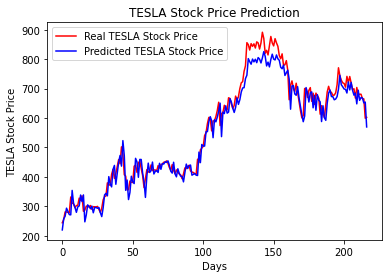

In [16]:
# PART 3 - Making the predicmodel visualizing 

# Getting the real stock price of the period of test dataset

dataset_test = pd.read_csv('Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values


# Getting the predicted stock price of the period

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 25:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# Creating Timesteps and reshaping test dataset into 3D shape to make it a valid input for LSTM algorithm

X_test = []

for i in range(25, len(inputs)):
    X_test.append(inputs[i-25:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicting Test dataset's stock values

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizing the results

plt.plot(real_stock_price, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [17]:
# Part 4 - Evaluating the Model (Computing the mean percentage of error)

dataFrame = pd.DataFrame(columns = ['real', 'predicted', 'absDiff', 'PercDiff'])

dataFrame['real'] = [i for j in real_stock_price for i in j]
dataFrame['predicted'] = [i for j in predicted_stock_price for i in j]
dataFrame['absDiff'] = abs(dataFrame['real'] - dataFrame['predicted'])
dataFrame['PercDiff'] = dataFrame['absDiff']*100/dataFrame['real']

print("Mean percentage of error +-" + str(dataFrame['PercDiff'].mean())+"%")


Mean percentage of error +-4.784074437533329%


(200.0, 700.0)

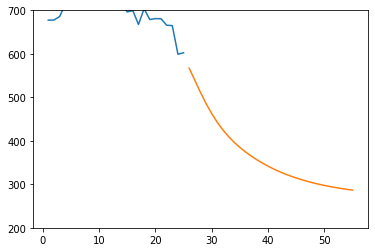

In [18]:
#PART 5 - PREDICTING FUTURE VALUE


dataset_test = pd.read_csv('Test.csv')
scaler=MinMaxScaler(feature_range=(0,1))
dataset_test = dataset_test.iloc[:, 1:2]
dataset_test=scaler.fit_transform(dataset_test).reshape(-1,1)

x_input = dataset_test[len(dataset_test)-25:].reshape(1,-1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

output=[]
n_steps=25
i=0
while(i<30):

    if(len(temp_input)>25):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
        i=i+1

print(" ")
day_new=np.arange(1,26)
day_pred=np.arange(26,56)



plt.plot(day_new,scaler.inverse_transform(dataset_test[192:]))
plt.plot(day_pred,scaler.inverse_transform(output))

plt.ylim([200,700])


